In [327]:
import numpy as np
import pandas as pd
import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import arff2pandas
import random

In [328]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [329]:
dataset_train = arff2pandas.load('ECG5000/ECG5000_TEST.arff')

c:\Users\ddani\LSTM Autoenconder -ECG\arff2pandas.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[df_str.columns] = df_str.applymap(lambda x:x.decode('utf-8'))


In [330]:
dataset_train.describe()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att131,att132,att133,att134,att135,att136,att137,att138,att139,att140
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,...,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,-0.273962,-1.660351,-2.497708,-3.121793,-3.166346,-2.862646,-2.271681,-1.797901,-1.407947,-0.934711,...,0.146259,0.073410,-0.060409,-0.273551,-0.502636,-0.753850,-0.824197,-0.630282,-0.474437,-0.694958
std,1.153257,1.448446,1.384922,1.300375,1.101844,0.906330,0.735420,0.628203,0.642411,0.660208,...,1.175640,1.410561,1.652410,1.899489,2.063698,2.087378,2.050563,1.848085,1.817460,1.411511
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.259295,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,...,-3.971715,-4.167040,-4.557576,-4.530488,-4.563270,-4.911417,-4.880460,-5.496107,-5.880890,-6.092227
25%,-1.018202,-2.710514,-3.675967,-4.221921,-4.006748,-3.472986,-2.779941,-2.164166,-1.773173,-1.360472,...,-0.667551,-1.104062,-1.598281,-2.157220,-2.743237,-3.014821,-2.856324,-2.131719,-1.635179,-1.577515
50%,-0.303240,-1.672456,-2.592071,-3.397653,-3.460329,-2.938500,-2.282163,-1.748535,-1.420713,-0.909183,...,0.481311,0.676028,0.732593,0.608052,0.335153,-0.025628,-0.180293,-0.191248,-0.144524,-0.551293
75%,0.485655,-0.684776,-1.519119,-2.240458,-2.530796,-2.397532,-1.822741,-1.483616,-1.059521,-0.476321,...,1.064272,1.173172,1.239463,1.267172,1.237470,1.037941,0.947254,0.948825,1.002692,0.277078
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,1.898627,...,2.880345,3.007606,2.854680,2.912134,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103


In [346]:
print("shape : ",dataset_train.shape)
print(dataset_train.iloc[:, -1].value_counts())
if dataset_train.isnull().sum().any():
    print('Tem colunas com valores nulos')
else:
    print('Nenhuma coluna tem valores nulos')

shape :  (4500, 141)
target
1    2627
2    1590
4     175
3      86
5      22
Name: count, dtype: int64
Nenhuma coluna tem valores nulos


target
1    2627
2    1873
Name: count, dtype: int64


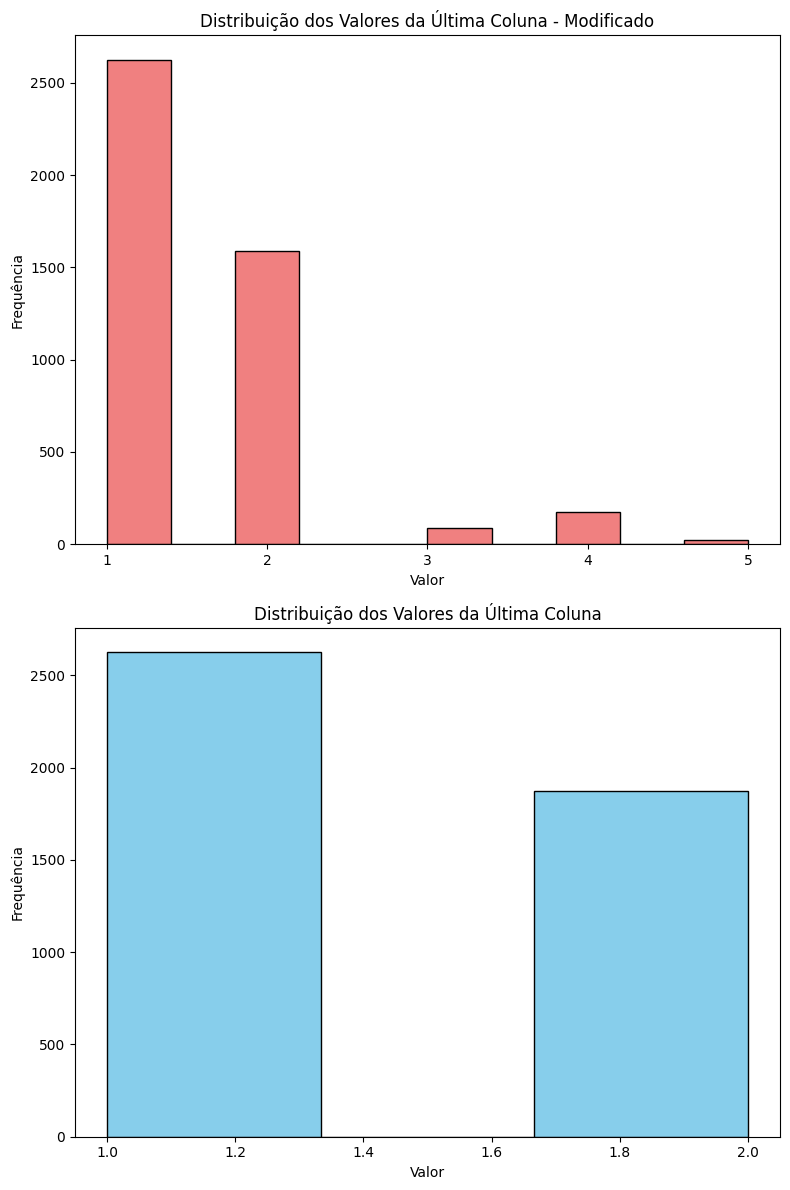

In [332]:
column_with_one = pd.to_numeric(dataset_train.iloc[:, -1], errors='coerce')
column_with_one = column_with_one.replace({3:2,4:2,5:2})


fig, axes = plt.subplots(2, 1, figsize=(8, 12))

print(column_with_one.value_counts())


axes[1].hist(column_with_one, bins=3, color='skyblue', edgecolor='black')
axes[1].set_title('Distribuição dos Valores da Última Coluna')
axes[1].set_xlabel('Valor')
axes[1].set_ylabel('Frequência')

axes[0].hist(dataset_train.iloc[:, -1], bins=10, color='lightcoral', edgecolor='black')
axes[0].set_title('Distribuição dos Valores da Última Coluna - Modificado')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frequência')


plt.tight_layout()  
plt.show()


In [333]:
dataset_train_normal = dataset_train[dataset_train.iloc[:, -1] == '1'].drop(dataset_train.columns[-1], axis=1)
data = dataset_train_normal.values.reshape((dataset_train_normal.shape[0], 140, 1))
df_train,df_val = train_test_split(data , test_size=0.20, random_state=42)


In [334]:
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout

model = Sequential()

# Codificador LSTM
model.add(LSTM(128, activation='tanh', input_shape=(140, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(LSTM(16, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))

# Camada de Bottleneck
model.add(RepeatVector(140))

# Decodificador LSTM
model.add(LSTM(16, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

model.fit(df_train, df_train,epochs=100,batch_size=4,validation_data=(df_val, df_val))


c:\Users\ddani\LSTM Autoenconder -ECG\ambiente311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_112 (LSTM)                 │ (None, 140, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 140, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_113 (LSTM)                 │ (None, 140, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_114 (LSTM)                 │ (None, 140, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_115 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_14 (RepeatVector) │ (None, 140, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_116 (LSTM)                 │ (None, 140, 16)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 140, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_117 (LSTM)                 │ (None, 140, 32)        │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_118 (LSTM)                 │ (None, 140, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_119 (LSTM)                 │ (None, 140, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 140, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 140, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,681 (1.01 MB)

 Trainable params: 263,681 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 138s 239ms/step - loss: 0.6126 - val_loss: 0.2160
Epoch 2/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 123s 235ms/step - loss: 0.2279 - val_loss: 0.1781
Epoch 3/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 123s 234ms/step - loss: 0.1847 - val_loss: 0.1410
Epoch 4/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 124s 236ms/step - loss: 0.1613 - val_loss: 0.1167
Epoch 5/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 125s 238ms/step - loss: 0.1440 - val_loss: 0.1145
Epoch 6/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 114s 216ms/step - loss: 0.1374 - val_loss: 0.1147
Epoch 7/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 114s 217ms/step - loss: 0.1282 - val_loss: 0.1026
Epoch 8/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 111s 210ms/step - loss: 0.1261 - val_loss: 0.1323
Epoch 9/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 111s 211ms/step - loss: 0.1226 - val_loss: 0.0946
Epoch 10/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 111s 211ms/step - loss: 0.1142 - val_loss: 0.1020
Epoch 11/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 112s 213ms/step - loss: 0.1120 - val_loss: 0.09

In [335]:
dataset_train_anomaly = dataset_train[dataset_train.iloc[:, -1] != '1'].drop(dataset_train.columns[-1], axis=1)
data_anomaly = dataset_train_anomaly.values.reshape((dataset_train_anomaly.shape[0], 140, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


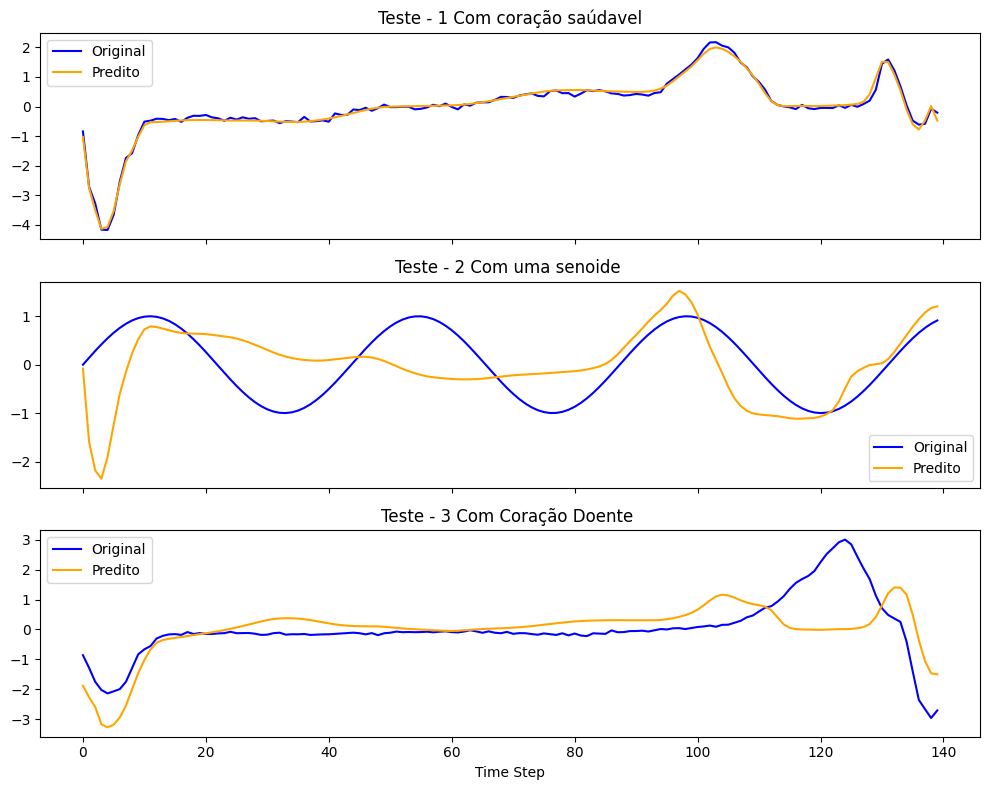

In [336]:

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Gráfico 1: sinal original
sample = df_val[10] 
sample_input = np.expand_dims(sample, axis=0)
reconstructed = model.predict(sample_input)[0]

axs[0].plot(sample, label='Original', color='blue')
axs[0].plot(reconstructed, label='Predito', color='orange')
axs[0].legend()
axs[0].set_title('Teste - 1 Com coração saúdavel')

# Gráfico 2: sinal reconstruído

sinal_teste = np.sin(np.linspace(0, 20, 140))  
sinal_teste = sinal_teste.reshape((1, 140, 1)) 
sinal_reconstruido = model.predict(sinal_teste)[0]

axs[1].plot(sinal_teste[0], label='Original', color='blue')
axs[1].plot(sinal_reconstruido, label='Predito', color='orange')
axs[1].legend()
axs[1].set_title('Teste - 2 Com uma senoide ')

# Gráfico 3: sinal reconstruído

sample_anomaly = data_anomaly[10] 
sample_input_anomaly = np.expand_dims(sample_anomaly, axis=0)
reconstructed_anomaly = model.predict(sample_input_anomaly)[0]

axs[2].plot(sample_anomaly, label='Original', color='blue')
axs[2].plot(reconstructed_anomaly, label='Predito', color='orange')
axs[2].legend()
axs[2].set_title('Teste - 3 Com Coração Doente ')


plt.xlabel('Time Step')
plt.tight_layout()
plt.show()


66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step


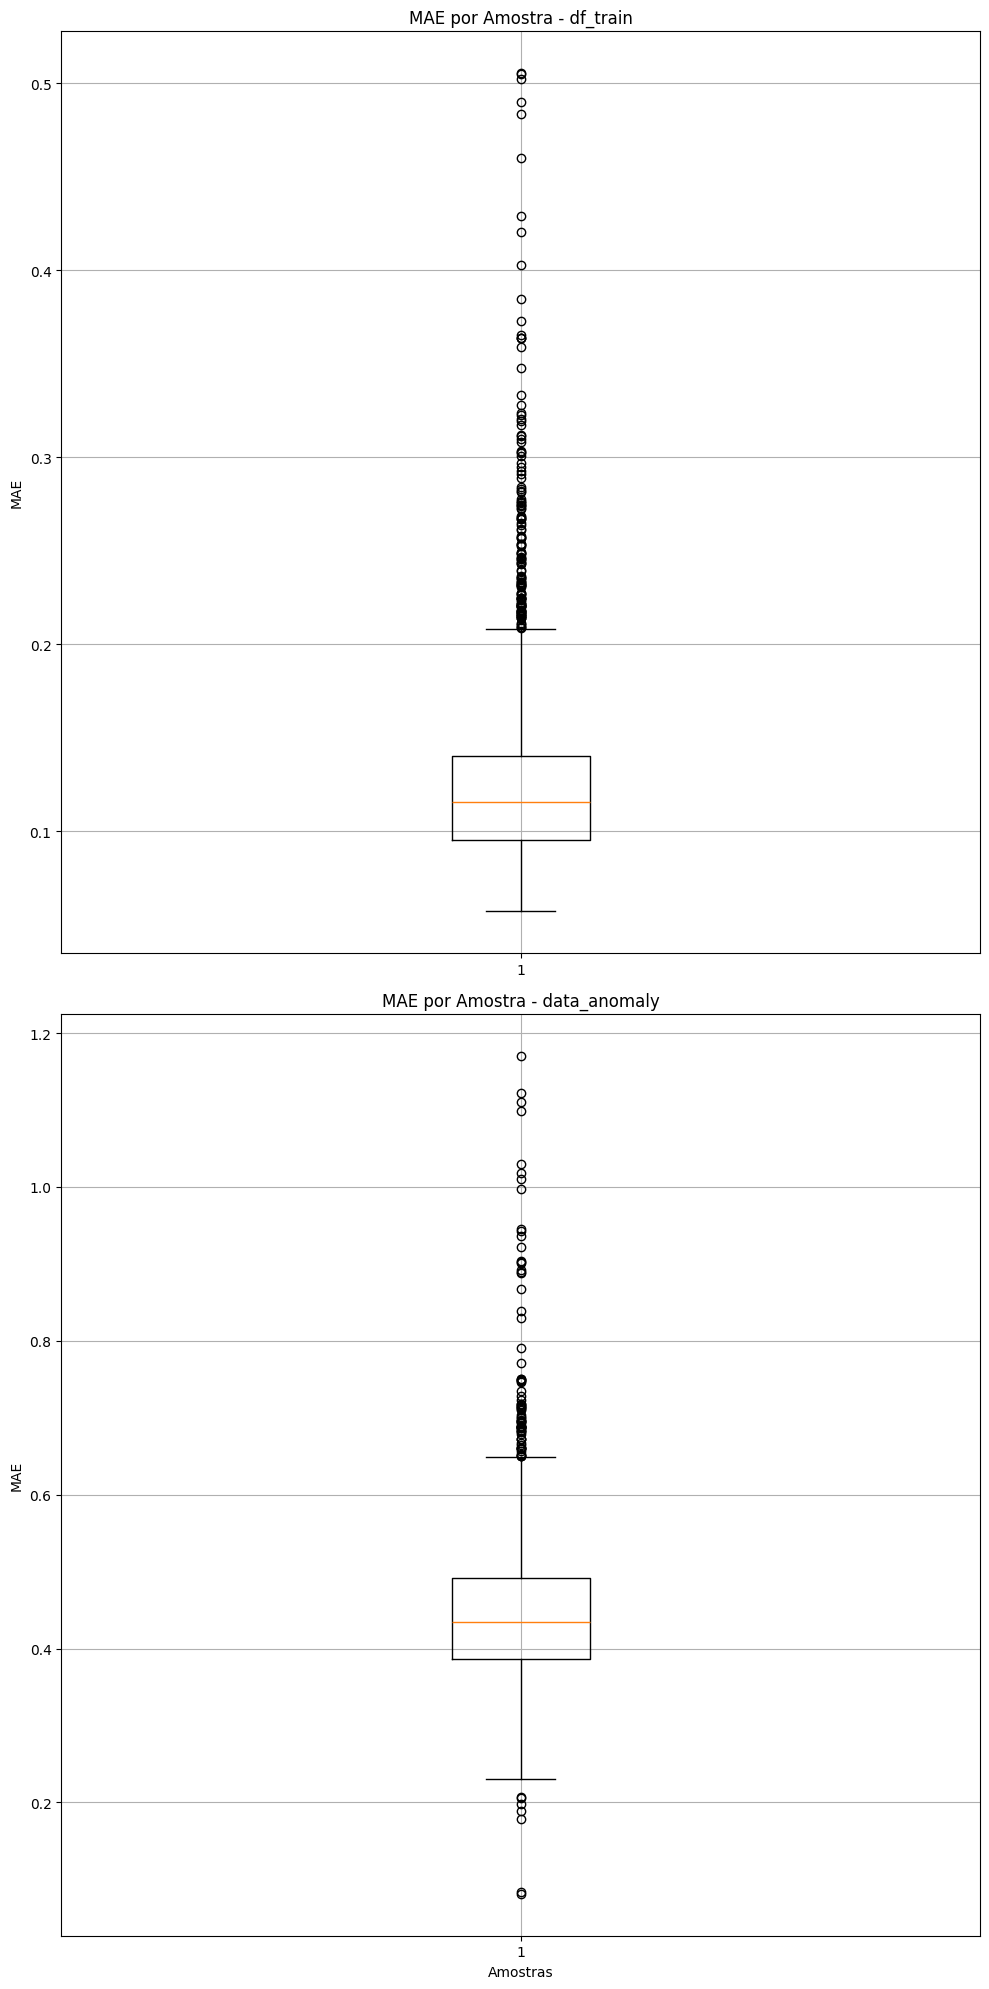

In [337]:
fig, axs = plt.subplots(2, 1, figsize=(10, 20))

# Boxplot 1 
reconstructed = model.predict(df_train)
mae_por_amostra = np.mean(np.abs(df_train - reconstructed), axis=(1, 2))

axs[0].boxplot(mae_por_amostra, vert=True)
axs[0].set_title('MAE por Amostra - df_train')
axs[0].set_ylabel('MAE')
axs[0].grid(True)

# Boxplot 2 
reconstructed = model.predict(data_anomaly)
mae_por_amostra2 = np.mean(np.abs(data_anomaly - reconstructed), axis=(1, 2))
axs[1].boxplot(mae_por_amostra2, vert=True)
axs[1].set_title('MAE por Amostra - data_anomaly')
axs[1].set_xlabel('Amostras')
axs[1].set_ylabel('MAE')
axs[1].grid(True)

plt.tight_layout()
plt.show()

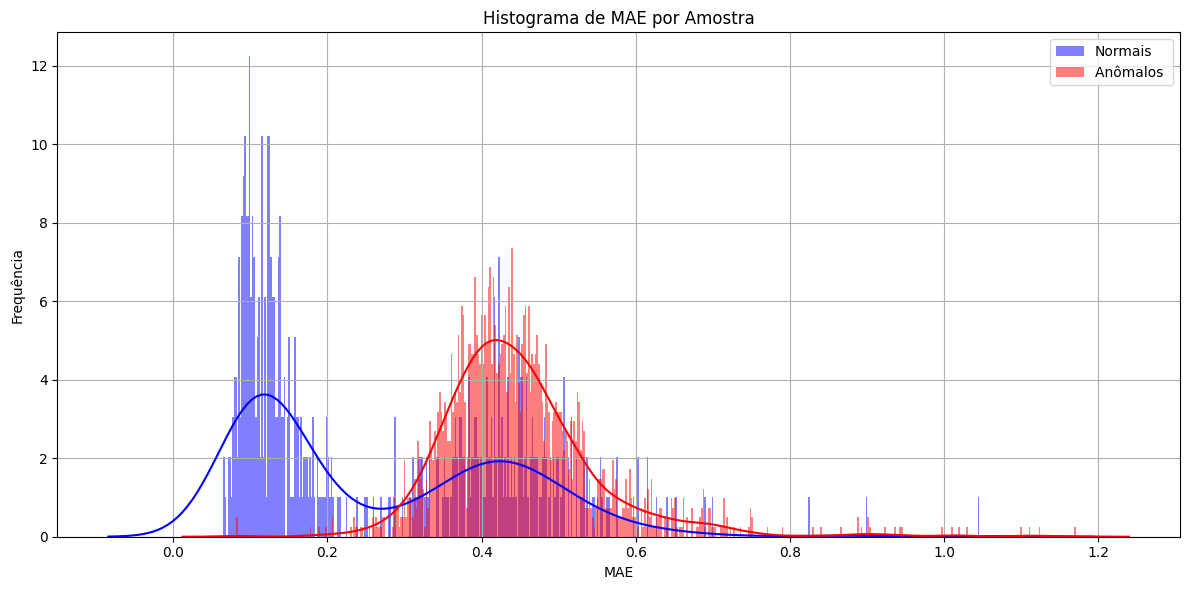

In [371]:
plt.figure(figsize=(12, 6))
plt.hist(mae_por_amostra, bins=500, alpha=0.5, label='Normais', color='blue', density=True)
plt.hist(mae_por_amostra2, bins=500, alpha=0.5, label='Anômalos ', color='red', density=True)
sns.kdeplot(mae_por_amostra, color='blue')
sns.kdeplot(mae_por_amostra2, color='red')
plt.title('Histograma de MAE por Amostra')
plt.xlabel('MAE')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [338]:
dataset_test = arff2pandas.load('ECG5000/ECG5000_TRAIN.arff')

c:\Users\ddani\LSTM Autoenconder -ECG\arff2pandas.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[df_str.columns] = df_str.applymap(lambda x:x.decode('utf-8'))


In [339]:
# Separação do dataset 
dataset_teste_pred = dataset_test.drop(dataset_test.columns[-1], axis=1)
dataset_teste_target = dataset_test.drop(dataset_test.columns[0:-1], axis=1)
dataset_teste_pred_reshape = dataset_teste_pred.values.reshape((dataset_teste_pred.shape[0], 140, 1))

# Classificando o dataset com limiar de 0.2
reconstructed = model.predict(dataset_teste_pred_reshape)
mae_por_amostra = np.mean(np.abs(dataset_teste_pred_reshape - reconstructed), axis=(1, 2))
classes = np.where(mae_por_amostra <= 0.2, 1, 2)

# preparando parte do dataset para comparação
dataset_teste_target_np = pd.to_numeric(dataset_teste_target.iloc[:,-1], errors='coerce')
dataset_teste_target_np = dataset_teste_target_np.replace({3:2,4:2,5:2})



16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


In [340]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(dataset_teste_target_np, classes)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9420


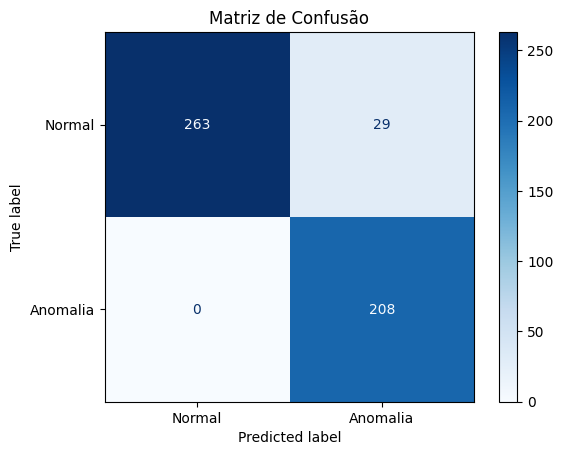

In [341]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(dataset_teste_target_np, classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalia"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão")
plt.show()

In [363]:
TP = cm[0][0]
FP = cm[0][1]
TN = cm[1][1]
FN = cm[1][0]

print(f'Sensibilidade: {(TN / (TN + FN) * 100):.2f}%')


Sensibilidade: 100.00%


In [342]:
model.save('LstmModel.h5')